In [24]:
from keras.models import Model
from keras.preprocessing import image
from tensorflow.keras.layers import Input, Lambda ,Dense ,Flatten ,Dropout
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import os
import cv2
import keras
from natsort import natsorted

## Get Data

In [25]:
def get_images(images_path):
    # speichert Bilder als numpy array

    array_images = []
    train_or_test_folder = os.listdir(images_path)

    for folder in natsorted(train_or_test_folder):
        single_folder = os.path.join(images_path, folder)

        for file in os.listdir(single_folder):
            filepath = os.path.join(single_folder, file)

            if filepath.lower().endswith(('.jpeg', '.jpg')):
                image = cv2.resize(cv2.imread(filepath), (64, 64))  # resize Größe bestimmt durch vortainiertes Netz
                array_images.append(image)

    images = np.array(array_images)
    
    return images

In [26]:
def get_label(images_path):
    # speichert Lables als numpy array

    array_label = []
    for folder in natsorted(os.listdir(images_path)):
        label = int(folder)

        for file in os.listdir(os.path.join(images_path, folder)):
            array_label.append(label)
    labels = np.array(array_label)
        
    return labels

In [27]:
images = get_images("../../02_data_crop/train") # train images
labels = get_label("../../02_data_crop/train")  # train labels

X_eval = get_images("../../02_data_crop/test")  # Evaluierungs Bilder
y_eval = get_label("../../02_data_crop/test")   # Evaluierungs Labels

In [28]:
uniq_labels = natsorted(os.listdir("../../02_data_crop/train"))
print("Anzahl eindeutiger Klassen: {}".format(len(uniq_labels)))

Anzahl eindeutiger Klassen: 26


## Preprocessing

In [29]:
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Trainingsbilder, Testbilder, Trainingslabels, Testlabels
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, stratify = labels)
# von jeder Klasse Daten

n = len(uniq_labels)   # Anzahl eindeutiger Klassen
train_n = len(X_train) # Anzahl Trainingsdaten
test_n = len(X_test)   # Anzahl Testdaten
eval_n = len(X_eval)

tab = [['Klassen:',n],
       ['Trainingsbilder', train_n],['Testbilder', test_n],['Evaluierungsbilder', eval_n]]

print(tabulate(tab, headers=["Anzahl", "Wert"]))

Anzahl                Wert
------------------  ------
Klassen:                26
Trainingsbilder       8294
Testbilder            2074
Evaluierungsbilder    1448


In [30]:
# one hot encoding der Labels
# Binarisierung, entsprechende Klasse mit 1 gekennzeichnet
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)
y_eval = keras.utils.to_categorical(y_eval)

In [31]:
print("One hot encoded: {}".format(y_train[0]))
print("Anzahl Klassen: {}".format(len(y_train[0])))
# Dummy Klasse, wenn kein Wert passt

One hot encoded: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
Anzahl Klassen: 27


In [32]:
# Normalisierung der Bilder, damit Werte nur noch zwischen 0 und 1
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_eval = X_eval.astype('float32')/255.0

## Model

In [33]:
# Netzwerkarchitektur
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
num_classes = 27
model = Sequential()

    # Detektion
model.add(Conv2D(32, kernel_size=(5,5), activation= 'relu', input_shape=(64,64,3))) # input shape der images

    # Conv_Block 2
model.add(Conv2D(64, kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

    # Identifikation
model.add(Flatten())
model.add(Dense(128, activation='relu', name='features'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(num_classes, activation='softmax')) # Anzahl der Klassen als Ausgabedimension angeben
model.summary()

c:\Users\KimJu\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 27)             │         1,755 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,486,363 (24.74 MB)

 Trainable params: 6,486,363 (24.74 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Festlegung der Verlustfunktion und Optimierung
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [35]:
batch_size = 32
#num_classes = 26
epochs = 10

history = model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Epoch 1/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 69s 237ms/step - accuracy: 0.1378 - loss: 2.9477 - val_accuracy: 0.5849 - val_loss: 1.4957
Epoch 2/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 60s 232ms/step - accuracy: 0.4835 - loss: 1.6199 - val_accuracy: 0.7835 - val_loss: 0.7899
Epoch 3/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 60s 229ms/step - accuracy: 0.6487 - loss: 1.1203 - val_accuracy: 0.8404 - val_loss: 0.5484
Epoch 4/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 59s 228ms/step - accuracy: 0.7287 - loss: 0.8744 - val_accuracy: 0.8852 - val_loss: 0.4371
Epoch 5/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 59s 228ms/step - accuracy: 0.7765 - loss: 0.6969 - val_accuracy: 0.8896 - val_loss: 0.4023
Epoch 6/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 60s 231ms/step - accuracy: 0.8112 - loss: 0.6093 - val_accuracy: 0.8959 - val_loss: 0.3502
Epoch 7/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 60s 229ms/step - accuracy: 0.8240 - loss: 0.5401 - val_accuracy: 0.9079 - val_loss: 0.3349
Epoch 8/10
260/260 ━━━━━━━━━━━━━━━━━━━━ 60s 230ms/step - accuracy: 0.8507 - loss: 0

In [36]:
# Saving the model of vgg16
#model.save('./Models/model_vgg16.h5')

In [37]:
score = model.evaluate(x = X_test, y = y_test, verbose = 0)
print('Accuracy for test images:', round(score[1]*100, 3), '%')
score = model.evaluate(x = X_eval, y = y_eval, verbose = 0)
print('Accuracy for evaluation images:', round(score[1]*100, 3), '%')

Accuracy for test images: 91.9 %
Accuracy for evaluation images: 78.384 %


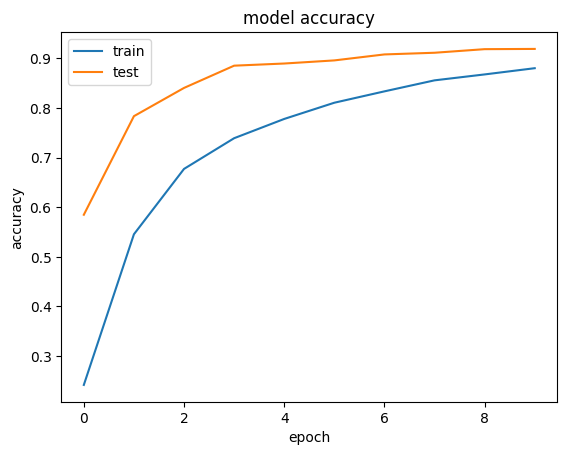

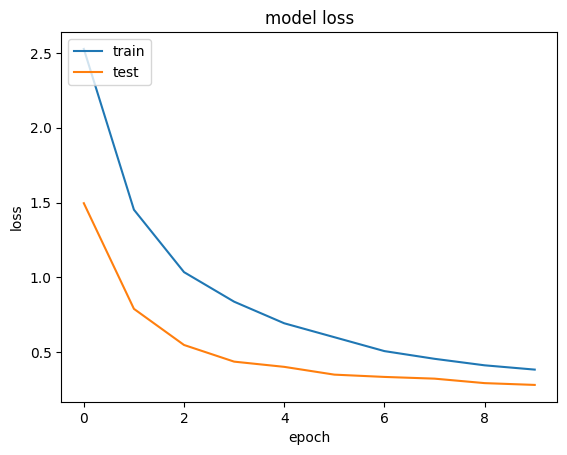

In [38]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

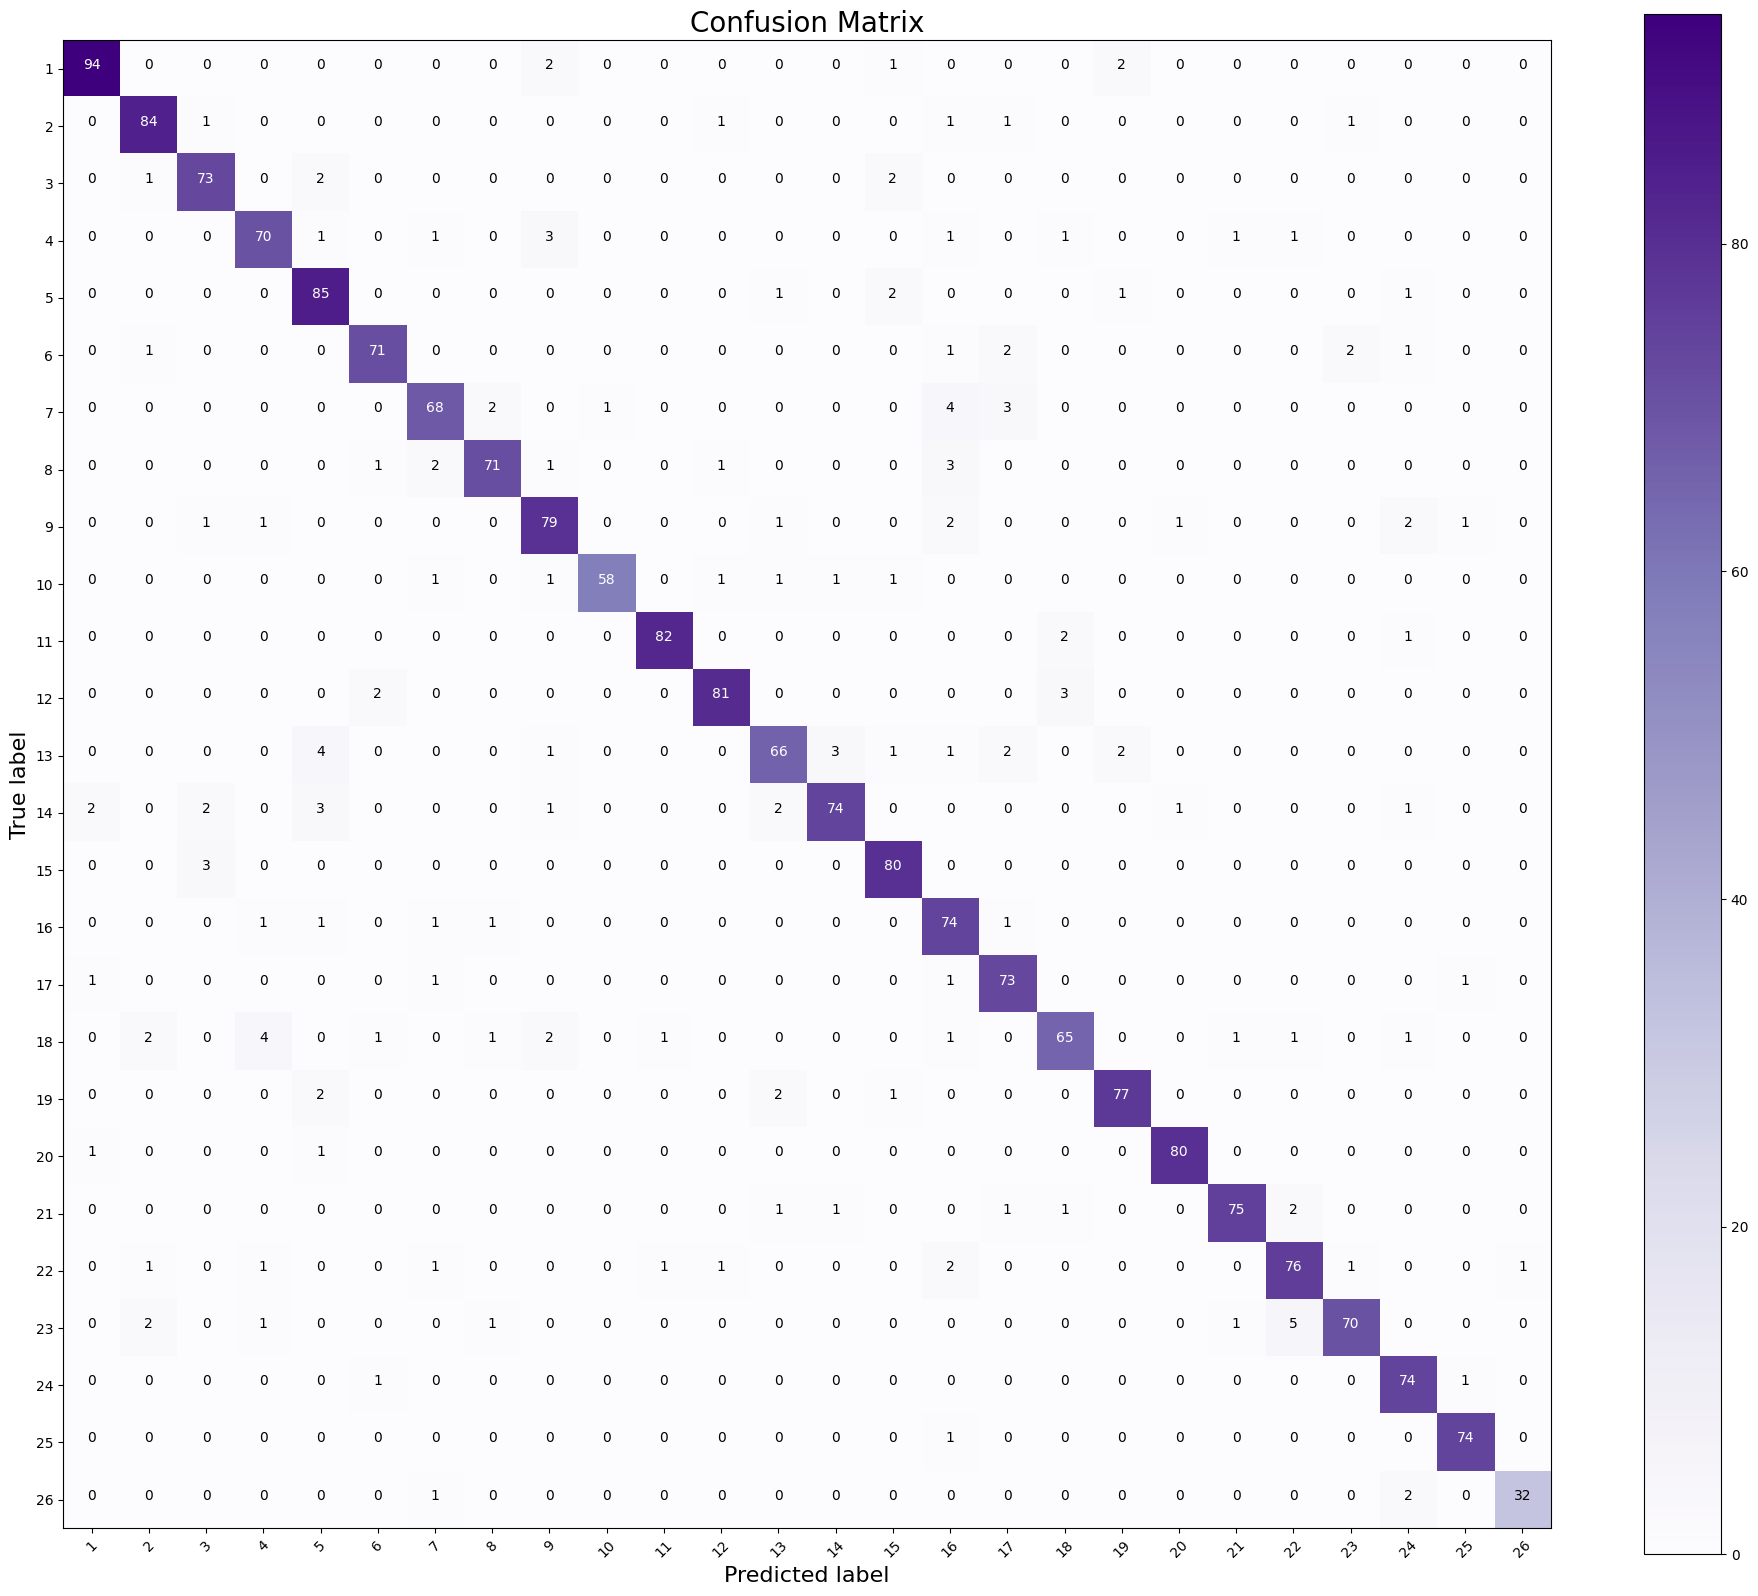

In [39]:
#Helper function to plot confusion matrix
def plot_confusion_matrix(y, y_pred):
    y = np.argmax(y, axis = 1)
    y_pred = np.argmax(y_pred, axis = 1)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize = (24, 20))
    ax = plt.subplot()
    plt.imshow(cm, interpolation = 'nearest', cmap = plt.cm.Purples)
    plt.colorbar()
    plt.title("Confusion Matrix")
    tick_marks = np.arange(len(uniq_labels))
    plt.xticks(tick_marks, uniq_labels, rotation=45)
    plt.yticks(tick_marks, uniq_labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.title.set_fontsize(20)
    ax.xaxis.label.set_fontsize(16)
    ax.yaxis.label.set_fontsize(16)
    limit = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment = "center",color = "white" if cm[i, j] > limit else "black")
    plt.show()

from sklearn.metrics import confusion_matrix
import itertools

y_test_pred = model.predict(X_test, batch_size = 64, verbose = 0)
plot_confusion_matrix(y_test, y_test_pred)

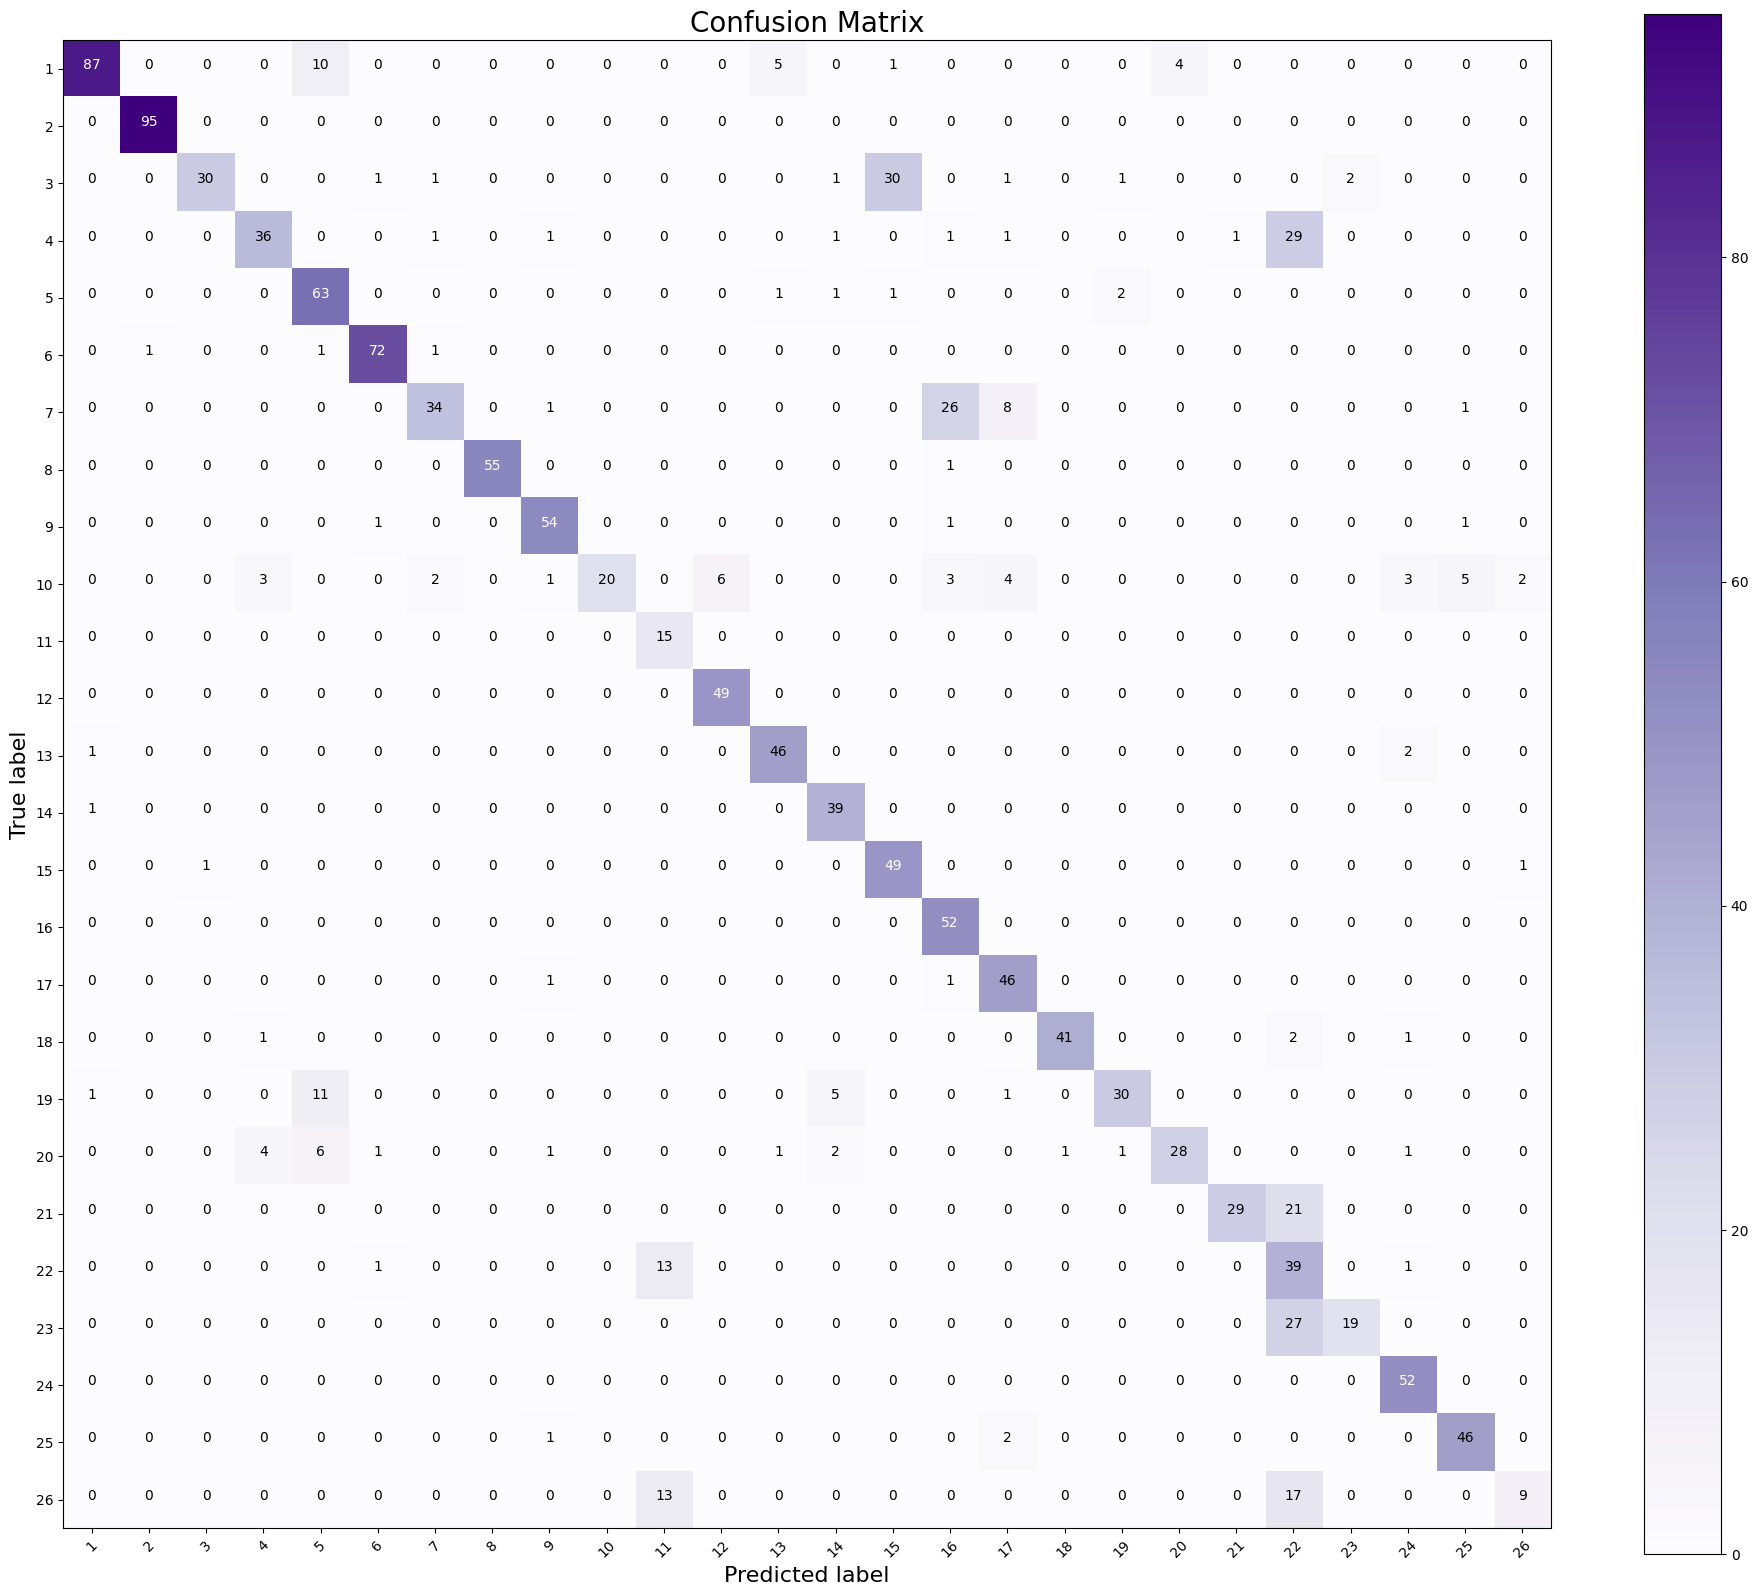

In [40]:
y_eval_pred = model.predict(X_eval, batch_size = 512,verbose = 0)
plot_confusion_matrix(y_eval, y_eval_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
0.0
G


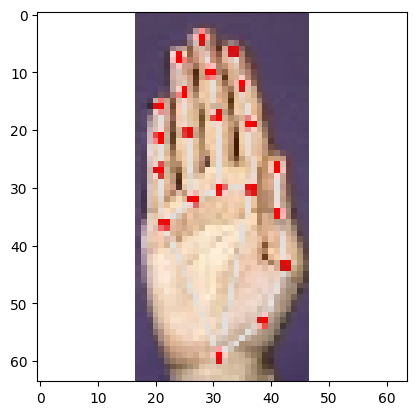

In [41]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('../test_images/00001.jpg',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
print(result[0])
print(result[0][12])


if result[0][0] == 1:
    prediction = 'A'
elif result[0][1] == 1:
    prediction = 'B'
elif result[0][2] == 1:
    prediction = 'C'
elif result[0][3] == 1:
    prediction = 'D'
elif result[0][4] == 1:
    prediction = 'E'
elif result[0][5] == 1:
    prediction = 'F'
elif result[0][6] == 1:
    prediction = 'G'
elif result[0][7] == 1:
    prediction = 'H'
elif result[0][8] == 1:
    prediction = 'I'
elif result[0][9] == 1:
    prediction = 'J'
elif result[0][10] == 1:
    prediction = 'K'
elif result[0][11] == 1:
    prediction = 'L'
elif result[0][12] == 1:
    prediction = 'M'
elif result[0][13] == 1:
    prediction = 'N'
elif result[0][14] == 1:
    prediction = 'O'
elif result[0][15] == 1:
    prediction = 'P'
elif result[0][16] == 1:
    prediction = 'Q'
elif result[0][17] == 1:
    prediction = 'R'
elif result[0][18] == 1:
    prediction = 'S'
elif result[0][19] == 1:
    prediction = 'T'
elif result[0][20] == 1:
    prediction = 'U'
elif result[0][21] == 1:
    prediction = 'V'
elif result[0][22] == 1:
    prediction = 'W'
elif result[0][23] == 1:
    prediction = 'X'
elif result[0][24] == 1:
    prediction = 'Y'
elif result[0][25] == 1:
    prediction = 'Z'


else:
    prediction = '  '
    
print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Vorhergesagte Klasse:  G


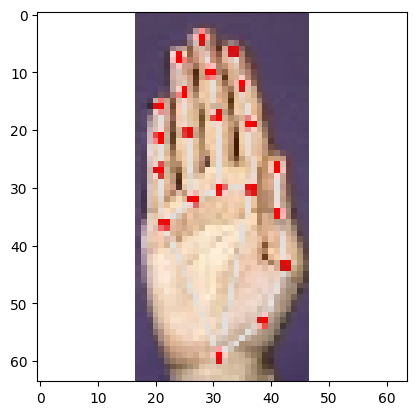

In [42]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('../test_images/00001.jpg',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)

# Finde den Index des höchsten Werts in result
predicted_class_index = np.argmax(result)

# Lade die Klassenbezeichnungen
class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'] # Füge hier deine Klassenbezeichnungen hinzu

# Zeige die Vorhersage an
print("Vorhergesagte Klasse: ", class_labels[predicted_class_index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
1.0
M


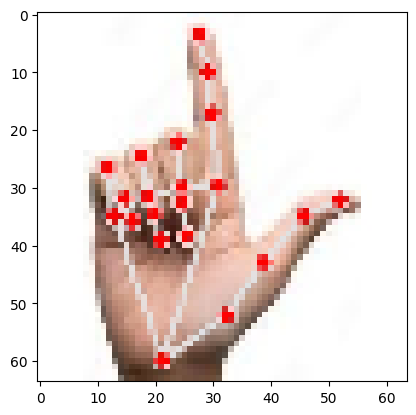

In [43]:
# for only one prediction
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('../test_images/00002.jpg',target_size=(64,64))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)
result = model.predict(test_image)
print(result[0])
print(result[0][12])


if result[0][0] == 1:
    prediction = 'A'
elif result[0][1] == 1:
    prediction = 'B'
elif result[0][2] == 1:
    prediction = 'C'
elif result[0][3] == 1:
    prediction = 'D'
elif result[0][4] == 1:
    prediction = 'E'
elif result[0][5] == 1:
    prediction = 'F'
elif result[0][6] == 1:
    prediction = 'G'
elif result[0][7] == 1:
    prediction = 'H'
elif result[0][8] == 1:
    prediction = 'I'
elif result[0][9] == 1:
    prediction = 'J'
elif result[0][10] == 1:
    prediction = 'K'
elif result[0][11] == 1:
    prediction = 'L'
elif result[0][12] == 1:
    prediction = 'M'
elif result[0][13] == 1:
    prediction = 'N'
elif result[0][14] == 1:
    prediction = 'O'
elif result[0][15] == 1:
    prediction = 'P'
elif result[0][16] == 1:
    prediction = 'Q'
elif result[0][17] == 1:
    prediction = 'R'
elif result[0][18] == 1:
    prediction = 'S'
elif result[0][19] == 1:
    prediction = 'T'
elif result[0][20] == 1:
    prediction = 'U'
elif result[0][21] == 1:
    prediction = 'V'
elif result[0][22] == 1:
    prediction = 'W'
elif result[0][23] == 1:
    prediction = 'X'
elif result[0][24] == 1:
    prediction = 'Y'
elif result[0][25] == 1:
    prediction = 'Z'


else:
    prediction = '  '
    
print(prediction)